## Using TensorFlow to Generate Images with PixelRNNs
Let's start by importing all the necessary dependencies.

Note that, as mentioned in the article, this notebook will use a faster, simpler version of the PixelRNN architecture called PixelCNN, which just relies on a series of masked convolutions.

In [1]:
import os

import numpy as np
from tqdm import tqdm
import tensorflow as tf

from utils import *
from ops import *
from statistic import Statistic

### Set up the parameters
Here we set all the paramaters for the PixelRNN model. These include the model hyperparameters, some dataset properties, and debugging information. We also set up the random seeds for Tensorflow and Numpy.

In [2]:
hyperparams = {# network
    "model" : "pixel_cnn", # name of model [pixel_rnn, pixel_cnn]
    "batch_size" : 100, # size of a batch
    "hidden_dims" : 16, # dimesion of hidden states of LSTM or Conv layers
    "recurrent_length" : 7, # the length of LSTM or Conv layers
    "out_hidden_dims" : 32, # dimesion of hidden states of output Conv layers
    "out_recurrent_length" : 2, # the length of output Conv layers
    "use_residual" : False, # whether to use residual connections or not
    "use_dynamic_rnn" : False, # whether to use dynamic_rnn or not
    "use_swapout" : True, # whether to use swapout or not
    "p1" : 0.4, # p1 in swapout
    "p2" : 0.9, # p2 in swapout

    # training
    "max_epoch" : 20, # # of step in an epoch
    "test_step" : 10, # # of step to test a model
    "save_step" : 5, # # of step to save a model
    "learning_rate" : 1e-3, # learning rate
    "grad_clip" : 1, # value of gradient to be used for clipping
    "use_gpu" : True, # whether to use gpu for training

    # data
    "data" : "mnist", # name of dataset 
    "data_dir" : "MNIST-data", # name of data directory
    "sample_dir" : "samples", # name of sample directory

    # Debug
    "is_train" : True, # training or testing
    "display" : False, # whether to display the training results or not
    "random_seed" :  123 # random seed for python
}
p = dotdict(hyperparams)

In [3]:
if "random_seed" in p:
    tf.set_random_seed(p.random_seed)
    np.random.seed(p.random_seed)

### Prepare the dataset

Next, let's load the MNIST image data from which we will train our model. [MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits, commonly used as a benchmark for machine learning tasks. We will try to generate images that look similar to those contained in the dataset.


In [4]:
# TODO add hyperparams to model saving
model_dir = setup_model_saving(p.model, p.data, hyperparams)
DATA_DIR = p.data_dir
SAMPLE_DIR = os.path.join(model_dir, p.sample_dir)

check_and_create_dir(DATA_DIR)
check_and_create_dir(SAMPLE_DIR)

# prepare dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

next_train_batch = lambda x: mnist.train.next_batch(x)[0]
next_test_batch = lambda x: mnist.test.next_batch(x)[0]

height, width, channel = 28, 28, 1

train_step_per_epoch = mnist.train.num_examples // p.batch_size
test_step_per_epoch = mnist.test.num_examples // p.batch_size

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


[06-10 12:24:17] From <ipython-input-4-40a25cf34cb6>:11: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use tf.data to implement this functionality.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST-data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Setting up network

Let's construct the PixelCNN model. First, we set up input placeholder. We'll be feeding batches of training images into the model through this.

Next, we construct the masked convolutional layers. You can find the implementation of this masking procedure in ```ops.py```. These layers apply a series of convolutions to the image, where each filter is masked to only account for pixels in the region of interest. These are the pixels above and to the left of the pixel in the center of the mask, which follows the PixelRNN generative model assumptions. Also of note is that the receptive field of the PixelCNN model grows linearly with the depth of these convolutional stacks.

After the convolutions, we apply a sigmoid activation to arrive at an estimate for the grayscale intensity for each pixel in the output image.

In [5]:
def pixelRNN(height, width, channel, params):
    """
    Args
    height, width, channel - the dimensions of the input
    params -- the hyperparameters of the network
    """
    input_shape = [None, height, width, channel] if params.use_gpu else [None, channel, height, width]
    inputs = tf.placeholder(tf.float32, input_shape)

    # input of main convolutional layers
    scope = "conv_inputs"
    conv_inputs = conv2d(inputs, params.hidden_dims, [7, 7], "A", scope=scope)
    
    
    # main convolutions layers
    last_hid = conv_inputs
    for idx in range(params.recurrent_length):
        scope = 'CONV%d' % idx
        if params.use_swapout and idx > 0:
            theta1 = params.p1 
            theta2 = params.p2
            noise_shape = array_ops.shape(last_hid)
            
            mask1 = math_ops.floor(theta1 + random_ops.random_uniform(noise_shape, seed=params.random_seed, dtype=last_hid.dtype))
            mask2 = math_ops.floor(theta2 + random_ops.random_uniform(noise_shape, seed= None if params.random_seed == None else params.random_seed * 2, dtype=last_hid.dtype))

            last_hid = last_hid * mask1 + conv2d(last_hid, 3, [1, 1], "B", scope=scope) * mask2
        else:
            last_hid = conv2d(last_hid, 3, [1, 1], "B", scope=scope)
        print("Building %s" % scope)


    # output convolutional layers
    for idx in range(params.out_recurrent_length):
        scope = 'CONV_OUT%d' % idx
        last_hid = tf.nn.relu(conv2d(last_hid, params.out_hidden_dims, [1, 1], "B", scope=scope))
        print("Building %s" % scope)

    conv2d_out_logits = conv2d(last_hid, 1, [1, 1], "B", scope='conv2d_out_logits')
    output = tf.nn.sigmoid(conv2d_out_logits)
    return inputs, output, conv2d_out_logits

inputs, output, conv2d_out_logits = pixelRNN(height, width, channel, p)

Instructions for updating:
Colocations handled automatically by placer.


[06-10 12:24:17] From /Users/erichan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


[06-10 12:24:17] Variable *= will be deprecated. Use `var.assign(var * other)` if you want assignment to the variable value or `x = x * y` if you want a new python Tensor object.


Building CONV0
Building CONV1
Building CONV2
Building CONV3
Building CONV4
Building CONV5
Building CONV6
Building CONV_OUT0
Building CONV_OUT1


### Optimization

Now, let's train the model. To do so, we will minimize the cross entropy loss using an RMSPropOptimizer. We also clip the gradients to help deal with potential exploding gradient problems.

In [6]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=conv2d_out_logits, labels=inputs, name='loss'))

optimizer = tf.train.RMSPropOptimizer(p.learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

new_grads_and_vars = \
    [(tf.clip_by_value(gv[0], -p.grad_clip, p.grad_clip), gv[1]) for gv in grads_and_vars]
optim = optimizer.apply_gradients(new_grads_and_vars)
 
# show_all_variables()
print("Building %s finished!" % p.model)

Building pixel_cnn finished!


### Image generation
To generate an image, we predict a single pixel at a time. Once we generate a pixel, the next prediction will use the previous pixels to generate the next pixel intensity using the masked convolutions. 

In [7]:
def predict(sess, images, inputs, output):
    return sess.run(output, {inputs: images})
def generate_occlusions(sess, height, width, inputs, output):
    samples = occlude(images, height, width)
    starting_position = [0,height//2]
    for i in range(starting_position[1], height):
        for j in range(starting_position[0], width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]
    return samples

def generate(sess, height, width, inputs, output):
    samples = np.zeros((100, height, width, 1), dtype='float32')

    for i in range(height):
        for j in range(width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]

    return samples

### Training

Now we start the actual training process. We initialize Tensorflow and load a Statistics class to keep track of the model and score statistics as we train.

Then, we go through our training epochs, generating a series of images, evaluating the loss and optimizing accordingly. Every epoch we also test the model by producing sample images and evaluating the performance on some test data. Finally, once training is finished, we generate the images to display.

In [8]:
# with tf.Session() as sess:
sess = tf.Session()
stat = Statistic(sess, p.data, model_dir, tf.trainable_variables(), p.test_step)
stat.load_model()
init = tf.global_variables_initializer()

sess.run(init)
stat.start()
print("Start training")

initial_step = stat.get_t() if stat else 0
# iterator = trange(p.max_epoch, ncols=70, initial=initial_step)
iterator = tqdm(range(p.max_epoch))

for epoch in iterator:
    # print('Start epoch')
    # 1. train
    total_train_costs = []
    for idx in range(train_step_per_epoch):
        images = binarize(next_train_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        _, cost = sess.run([optim, loss], feed_dict={ inputs: images })
        total_train_costs.append(cost)
    # print('Start testing')
    # 2. test
    total_test_costs = []
    for idx in range(test_step_per_epoch):
        images = binarize(next_test_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        cost = sess.run(loss, feed_dict={ inputs : images })
        total_test_costs.append(cost)

    avg_train_cost, avg_test_cost = np.mean(total_train_costs), np.mean(total_test_costs)

    stat.on_step(avg_train_cost, avg_test_cost)
    # print('Start generation')
    # 3. generate samples
    samples = generate_occlusions(sess, height, width, inputs, output)
    path = save_images(samples, height, width, 10, 10, 
        directory=SAMPLE_DIR, prefix="epoch_%s" % epoch)
    iterator.set_description("train loss: %.3f, test loss: %.3f" % (avg_train_cost, avg_test_cost))

  0%|          | 0/20 [00:00<?, ?it/s]

Start training


train loss: 0.140, test loss: 0.139: 100%|██████████| 20/20 [25:31<00:00, 74.15s/it]


In [12]:
# with tf.Session() as sess:
samples = generate_occlusions(sess, height, width, inputs, output)
save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)

RuntimeError: Attempted to use a closed Session.

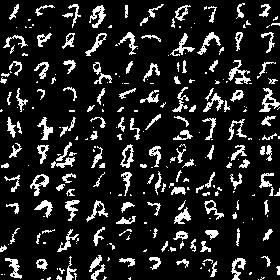

In [13]:
from IPython.display import Image
fname = save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)
Image(filename=fname)

Once we are done, we close our Tensorflow session.

In [11]:
sess.close()